# 🧬 Transcription Factor Binding Prediction with Foundation Model

Welcome to this comprehensive tutorial where we'll explore how to predict Transcription Factor Binding (TFB) sites on plant DNA sequences using **OmniGenBench** and **PlantRNA-FM** (Plant RNA Foundation Model). This guide demonstrates the practical application of plant-specialized genomic deep learning for regulatory genomics.

> 📚 **Prerequisites**: If you're new to OmniGenBench, we strongly recommend starting with the **[Fundamental Concepts Tutorial](https://github.com/yangheng95/OmniGenBench/blob/master/examples/00_fundamental_concepts.ipynb)**. It covers essential topics including language model concepts, machine learning task classification, foundation model principles (particularly PlantRNA-FM), and other foundational knowledge.

### 1. The Biological Challenge: Plant Transcription Factor Binding

**Transcription Factors (TFs)** are essential proteins that regulate gene expression in plants, controlling processes from development to stress responses. They bind to specific DNA sequences in regulatory regions. Identifying these binding sites is critical for understanding plant gene regulation, which is fundamental to crop improvement, stress tolerance, and developmental biology.

However, experimentally identifying TF binding sites across plant genomes is slow and expensive. This is where **PlantRNA-FM** (published in *Nature Machine Intelligence*, 35M parameters), a plant-specialized foundation model, can make a significant impact by learning plant-specific regulatory patterns efficiently.

### 2. The Data: Plant Regulatory Genomics Dataset

To train a model for this task, we use a curated dataset of plant regulatory regions, adapted from the **DeepSEA dataset** for plant genomics applications.

- **What it contains**: 1000-base-pair DNA sequences from plant genomes (Arabidopsis, rice, maize).
- **What it labels**: Each sequence is associated with 919 binary labels indicating the presence or absence of various chromatin features, including plant TF binding, DNase I sensitivity, and histone marks specific to plant genomes.
- **Our Goal**: Train PlantRNA-FM to predict which of the 919 features are present for any given plant DNA sequence.

| sequence (1000 bases) | label (919) |
|---------|-------|
| AUGGCCAUUGUAAUUGGCCGACUUGA... | [0,1,1,0...,1,0,0,1] |
| AUGGCUACUAGCUAGCUAGCUAGC... | [1,1,1,0...,0,0,1,1] |
| ... | ... |

Find the dataset template in **[Dataset Template](https://github.com/yangheng95/OmniGenBench/blob/master/examples/tfb_prediction/05_advanced_dataset_creation.ipynb)** and customize it as needed for your experiments.

### 3. Quick Start: Transcription Factor Binding Prediction Workflow

This tutorial demonstrates the practical application of the **[Fundamental Concepts Tutorial](https://github.com/yangheng95/OmniGenBench/blob/master/00_fundamental_concepts.ipynb)** to a specific biological problem. We'll use the standard 4-step OmniGenBench workflow:


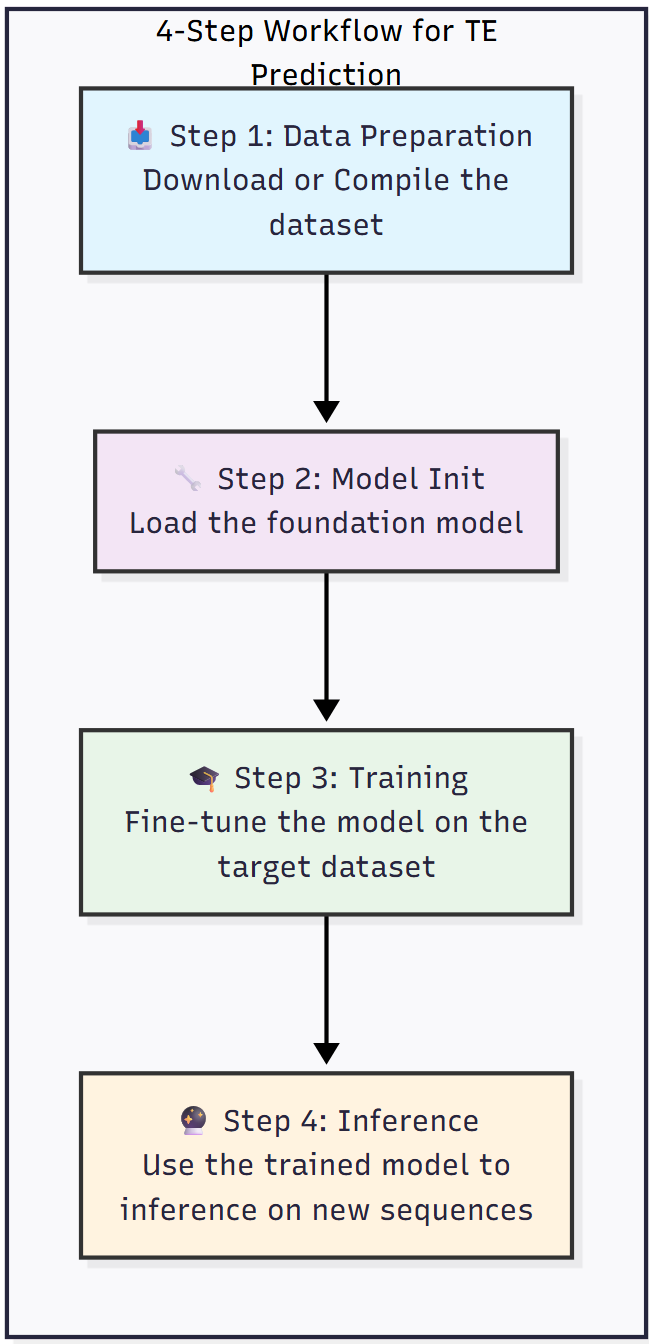

In [5]:
from IPython.display import Image, display
display(Image(filename="4-step workflow.png", width=300))

**Transcription Factor Binding Prediction** is a **multi-label classification** task where we predict which transcription factors will bind to plant DNA sequences. We'll use `OmniModelForMultiLabelSequenceClassification` with **PlantRNA-FM** to leverage plant-specific regulatory patterns learned during pre-training.

### 4. Tutorial Structure

1. **[Data Preparation](https://github.com/yangheng95/OmniGenBench/blob/main/examples/tfb_prediction/01_data_preparation.ipynb)**: Download and preprocess plant regulatory genomics data for multi-label classification
2. **[Model Initialization](https://github.com/yangheng95/OmniGenBench/blob/main/examples/tfb_prediction/02_model_initialization.ipynb)**: Load PlantRNA-FM and configure it for multi-label plant TFB prediction
3. **[Model Training](https://github.com/yangheng95/OmniGenBench/blob/main/examples/tfb_prediction/03_model_training.ipynb)**: Fine-tune PlantRNA-FM using plant genomic data and validate its performance
4. **[Model Inference](https://github.com/yangheng95/OmniGenBench/blob/main/examples/tfb_prediction/04_model_inference.ipynb)**: Use the trained model to predict transcription factor binding sites on new plant DNA sequences

Let's get started!

## 🚀 Step 1: Data Preparation

This first step is all about getting our data ready for in-silico analysis. It involves four key parts:
1.  **Environment Setup**: Installing and importing the necessary libraries.
2.  **Configuration**: Defining all our important parameters in one place.
3.  **Data Acquisition**: Downloading and preparing the raw dataset.
4.  **Data Loading**: Creating a pipeline to efficiently feed data to the model.

### 1.1: Environment Setup

First, let's install the required Python packages. `omnigenbench` is our core library, `transformers` provides the underlying model architecture, and the other packages are utilities for our workflow.

In [ ]:
!pip install -U omnigenbench

Next, we import the libraries we just installed. This gives us the tools for data processing, deep learning, and interacting with the operating system.

A key part of this setup is determining the best available hardware for training. Our script will automatically prioritize a **CUDA-enabled GPU** if one is available, as this can accelerate training by 10-100x compared to a CPU. This makes a huge difference when working with large models and datasets.

In [ ]:
import torch
import numpy as np

from omnigenbench import (
    ClassificationMetric,
    AccelerateTrainer,
    ModelHub,
    OmniTokenizer,
    OmniDatasetForMultiLabelClassification,
    OmniModelForMultiLabelSequenceClassification,
)


### 1.2: Global Configuration

To make our tutorial easy to modify and understand, we'll centralize all important parameters in this section. This is a best practice in software development that makes experiments more reproducible.

#### Key Parameters
-   **Dataset**: We define the local path and download URL for our dataset.
-   **Model**: We select which pre-trained OmniGenome model to use. For this tutorial, we'll start with `OmniGenome-52M` because it's fast and efficient, making it perfect for learning and prototyping.

This centralized approach allows you to easily experiment with different settings (e.g., a larger model, a different learning rate) without having to hunt through the code.

#### Note
Almost all the parameters here are standard in machine learning workflows and have a default value that works well if you don't set them. Don't worry if some of these terms are unfamiliar right now. We'll explain each one as we go along.

In [ ]:
model_name_or_path = "yangheng/PlantRNA-FM"  # Plant RNA Foundation Model
dataset_name = "deepsea_tfb_prediction"

### 1.3: Data Acquisition

With our environment configured, it's time to download the DeepSEA dataset. The function below automates this process by:
1.  Checking if the data already exists.
2.  Downloading the dataset from the specified URL if needed.
3.  Extracting the files.
4.  Cleaning up the temporary zip file.

This ensures we have the `train.jsonl`, `valid.jsonl`, and `test.jsonl` files ready for the next stage. These files represent the standard splits for training, validating, and testing our model.

In [ ]:
# Load tokenizer and datasets using enhanced OmniDataset
tokenizer = OmniTokenizer.from_pretrained(model_name_or_path)

datasets = OmniDatasetForMultiLabelClassification.from_hub(
    dataset_name=dataset_name,
    tokenizer=tokenizer,
    max_length=512,
    max_examples=1000,  # For quick testing; set to None for full dataset 440M examples
    force_padding=False  # The sequence length is fixed, so no need to pad sequence and labels
)

### 1.4: Dataset Loading with OmniGenBench

With OmniGenBench, data loading is significantly simplified! The framework automatically handles:

#### Automatic Data Processing
The `OmniDatasetForMultiLabelClassification` class automatically:
1.  **Downloads and processes** the dataset from Hugging Face Hub
2.  **Handles sequence preprocessing** including truncation, padding, and tokenization
3.  **Manages multi-label formatting** for TF binding prediction
4.  **Creates train/validation/test splits** ready for training

This streamlined approach eliminates the need for custom dataset classes while maintaining full flexibility and performance.

In [ ]:
print("📝 Data loading completed! Using  OmniDataset framework.")
print(f"📊 Loaded datasets: {list(datasets.keys())}")
for split, dataset in datasets.items():
    print(f"  - {split}: {len(dataset)} samples")

## 🚀 Step 2: Model Initialization with PlantRNA-FM

With our data pipeline in place, it's time to set up **PlantRNA-FM**. Instead of building a model from scratch, we'll load the pre-trained PlantRNA-FM and adapt it for our plant transcription factor binding prediction task, leveraging its plant-specific pre-training on regulatory regions.

The `OmniModelForMultiLabelSequenceClassification` class from our library handles this process for us, seamlessly combining the base model and the new classification head.
In adddition, most of the models and datasets have been integrated into the OmniGenBench package, making it easy to load them with just a few lines of code. Please refer to the sub-tutorials of [data preparation](https://github.com/yangheng95/OmniGenBench/blob/main/examples/tfb_prediction/02_data_preparation.ipynb) and [model initialization](https://github.com/yangheng95/OmniGenBench/blob/main/examples/tfb_prediction/03_model_initialization.ipynb) for more details.

...existing code...

In [ ]:
# === Model Initialization ===
# We almost support all genomic foundation models from Hugging Face Hub.

model = OmniModelForMultiLabelSequenceClassification(
    model_name_or_path,
    tokenizer,
    num_labels=919,
)

## 🚀 Step 3: Model Training

This is the most exciting part! With our data and model ready, we can now begin the **fine-tuning** process. During training, the model will learn to associate specific patterns in the DNA sequences with the presence or absence of TF binding sites.

The `AccelerateTrainer` from `omnigenbench` wraps all this logic into a simple interface, allowing us to launch the training process with just a few lines of code.

In [ ]:
metric_functions = [ClassificationMetric(ignore_y=-100).roc_auc_score]

trainer = AccelerateTrainer(
    model=model,
    train_dataset=datasets["train"],
    eval_dataset=datasets["valid"],
    test_dataset=datasets["test"],
    compute_metrics=metric_functions,

)
print("🎓 Starting training...")

metrics = trainer.train()
trainer.save_model("ogb_tfb_finetuned")

print('Metrics:', metrics)

## 🔮 Step 4: Model Inference and Interpretation

Now that we have a trained model, let's use it for its intended purpose: predicting TF binding sites on new DNA sequences. This process is called **inference**.

### The Inference Pipeline

Our inference pipeline consists of a few key steps:
1.  **Load the Model**: We load the best-performing model that was saved during training.
2.  **Process the Input**: We take a new DNA sequence and apply the same preprocessing steps we used for our training data (truncating/padding and tokenizing).
3.  **Run Prediction**: We feed the processed sequence to the model and get its predictions. We use `torch.no_grad()` to disable gradient calculations, which makes inference faster and uses less memory.
4.  **Interpret the Results**: The model's raw output is a set of probabilities. We'll interpret these to make them more understandable, identifying which TFs are predicted to bind and with what level of confidence.

To demonstrate, we'll test our model on a few sample sequences and print out a user-friendly summary of the results. This shows how the model can be used in a real-world application to analyze sequences of interest.

In [ ]:

inference_model = ModelHub.load("yangheng/ogb_tfb_finetuned")

sample_sequences = {
    "Random sequence": "AGCT" * (128 // 4),
    "AT-rich sequence": "AATT" * (128 // 4),
    "GC-rich sequence": "GCGC" * (128 // 4),
}
with torch.no_grad():

    for seq_name, sequence in sample_sequences.items():
        outputs = inference_model.inference(sequence)
        print("✅ Prediction completed!")

        # —— 结果解释 ——
        predictions = outputs.get('predictions', None)
        probabilities = outputs.get('probabilities', None)
        predictions = np.array(predictions)
        probabilities = np.array(probabilities) if probabilities is not None else None

        positive_count = np.sum(predictions == 1)
        total_count = len(predictions)

        print(f"📊 Prediction summary:")
        print(f"  🎯 Total TF binding sites analyzed: {total_count}")
        print(f"  ✅ Predicted binding sites: {positive_count}")
        print(f"  📈 Binding rate: {positive_count/total_count:.1%}")

        if probabilities is not None:
            print(f"\n🏆 Top 5 highest confidence predictions:")
            sorted_indices = np.argsort(probabilities)[::-1]

            for i, idx in enumerate(sorted_indices[:5]):
                tf_id = idx + 1
                prediction = "Binding" if predictions[idx] == 1 else "No binding"
                confidence = probabilities[idx]

                if confidence > 0.8:
                    emoji = "🔥"
                elif confidence > 0.6:
                    emoji = "⭐"
                elif confidence > 0.4:
                    emoji = "💫"
                else:
                    emoji = "💭"

                print(f"  {emoji} TF-{tf_id:03d}: {prediction} (confidence: {confidence:.3f})")

## 🎉 Tutorial Summary and Next Steps

Congratulations! You have successfully completed this comprehensive tutorial on transcription factor binding prediction with OmniGenBench.

### What You've Learned

You've walked through a complete, end-to-end MLOps workflow, a critical skill in modern computational biology. Specifically, you have:

1.  **Understood the "Why"**: Gained an appreciation for the biological problem of TFB prediction and how Genomic Foundation Models provide a powerful solution.

2.  **Mastered the 4-Step Workflow**:
    -   **Step 1: Data Preparation**: You learned how to acquire, process, and efficiently load a large-scale genomic dataset using the enhanced OmniDataset framework.
    -   **Step 2: Model Initialization**: You saw how to leverage a powerful pre-trained model and adapt it for multi-label sequence classification tasks.
    -   **Step 3: Model Training**: You implemented a robust training strategy using AccelerateTrainer with proper evaluation metrics and model persistence.
    -   **Step 4: Model Inference**: You used your fine-tuned model to make predictions on new DNA sequences and interpreted the results for biological insights.

Thank you for following along. We hope this tutorial has provided you with the knowledge and confidence to apply deep learning to your own genomics research. The future of computational biology is in your hands! 


### 🚀 Next Steps

Now that you've mastered translation efficiency prediction, you can:

#### 🧬 **Explore Other Sequence Classification Tasks**
- **Promoter Recognition**: Identify regulatory sequences
- **Subcellular Localization**: Predict protein cellular destinations  
- **Functional Annotation**: Classify protein or RNA functions

#### 📊 **Try Different Task Types**
- **Sequence Regression**: Gene expression level prediction
- **Token Classification**: Binding site identification
- **Multi-label Classification**: Multi-functional sequence prediction

#### 🔬 **Advanced Techniques**
- **Custom Dataset Creation**: Use the [Advanced Dataset Creation Tutorial](https://github.com/yangheng95/OmniGenBench/blob/main/examples/tfb_prediction/05_advanced_dataset_creation.ipynb)
- **Model Comparison**: Benchmark different foundation models
- **Hyperparameter Optimization**: Fine-tune model performance
- **Biological Validation**: Compare predictions with experimental data

### 📚 Resources

- **[Fundamental Concepts Tutorial](https://github.com/yangheng95/OmniGenBench/blob/main/00_fundamental_concepts.ipynb)**: Review core concepts anytime
- **[OmniGenBench Documentation](https://omnigenbench.readthedocs.io/)**: Complete API reference
- **[GitHub Repository](https://github.com/yangheng95/OmniGenBench)**: Source code and community discussions

Thank you for following along. We hope this tutorial has provided you with the knowledge and confidence to apply deep learning to your own genomics research. 

**Happy coding and discovering! 🧬✨**